# Distribution des continents dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des continents relatifs aux pays d'appartenance, en relation aux années de naissance de la population retenue.


In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            (MAX(?gen) as ?gen) ( GROUP_CONCAT(?continentLabel; separator=", ") AS ?onctinents )
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?s wdt:P21 ?gen;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        ## Excluding Eurasia, Australia and Oceania insular
        FILTER ( ?continent NOT IN (wd:Q538, wd:Q3960, wd:Q5401))
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

17491


[['http://www.wikidata.org/entity/Q97193482',
  'Q97193482',
  '1941',
  'http://www.wikidata.org/entity/Q6581097',
  'Asia, Europe, Europe'],
 ['http://www.wikidata.org/entity/Q4706857',
  'Alan Herries Wilson',
  '1906',
  'http://www.wikidata.org/entity/Q6581097',
  'Europe'],
 ['http://www.wikidata.org/entity/Q61552351',
  'Gerald E. Tauber',
  '1922',
  'http://www.wikidata.org/entity/Q6581097',
  'Asia, North America, North America']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'genderUri', 'continents']
df_p.head()

,personUri,personLabel,birthYear,genderUri,continents
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,http://www.wikidata.org/entity/Q6581097,"Asia, Europe, Europe"
1,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,http://www.wikidata.org/entity/Q6581097,Europe
2,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,http://www.wikidata.org/entity/Q6581097,"Asia, North America, North America"
3,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,http://www.wikidata.org/entity/Q6581097,Europe
4,http://www.wikidata.org/entity/Q18627816,Elmārs Blūms,1936,http://www.wikidata.org/entity/Q6581097,Europe


In [9]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17491 entries, 0 to 17490
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    17491 non-null  object
 1   personLabel  17491 non-null  object
 2   birthYear    17491 non-null  object
 3   genderUri    17491 non-null  object
 4   continents   17491 non-null  object
dtypes: object(5)
memory usage: 683.4+ KB


## Coder les continents et afficher leur distribution

In [10]:
def codeContinents(continents):
    listContinents = sorted(continents.split(','))
    if 'Europe' in listContinents:
        output = 'Europe'
    elif 'Asia' in listContinents:
        output = 'Asia'
    elif 'Africa' in listContinents:
        output = 'Africa'
    elif 'Oceania' in listContinents:
        output = 'Oceania'   
    elif 'North America' in listContinents:
        output = 'NorthAmerica'   
    elif 'South America' in listContinents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [11]:
codeContinents('Oceania, North America, Africa')

'Oceania'

In [12]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,http://www.wikidata.org/entity/Q6581097,"Asia, Europe, Europe",Asia
1,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,http://www.wikidata.org/entity/Q6581097,Europe,Europe
2,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,http://www.wikidata.org/entity/Q6581097,"Asia, North America, North America",Asia


In [13]:
df_p.iloc[ 115:120 :  ]

,personUri,personLabel,birthYear,genderUri,continents,contCode
115,http://www.wikidata.org/entity/Q12302291,Asger Lundbak,1914,http://www.wikidata.org/entity/Q6581097,Europe,Europe
116,http://www.wikidata.org/entity/Q1652897,John D. Lindl,1946,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
117,http://www.wikidata.org/entity/Q2798144,Richard F. Casten,1941,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
118,http://www.wikidata.org/entity/Q95123283,Jan Kaczér,1919,http://www.wikidata.org/entity/Q6581097,Europe,Europe
119,http://www.wikidata.org/entity/Q114191385,Q114191385,1946,http://www.wikidata.org/entity/Q6581097,"Europe, Asia, Europe",Europe


In [14]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Africa              76
Oceania            238
SouthAmerica       250
Asia              2332
NorthAmerica      3951
Europe           10644


In [15]:


df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Africa,76,0.43
Oceania,238,1.36
SouthAmerica,250,1.43
Asia,2332,13.33
NorthAmerica,3951,22.59
Europe,10644,60.85


In [16]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Asia,SouthAmerica,Oceania,Africa
frequence,60.85,22.59,13.33,1.43,1.36,0.43


In [17]:
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#DC143C",   # Crimson : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    "#A3C1DA"  # Light Blue : Africa
    
]


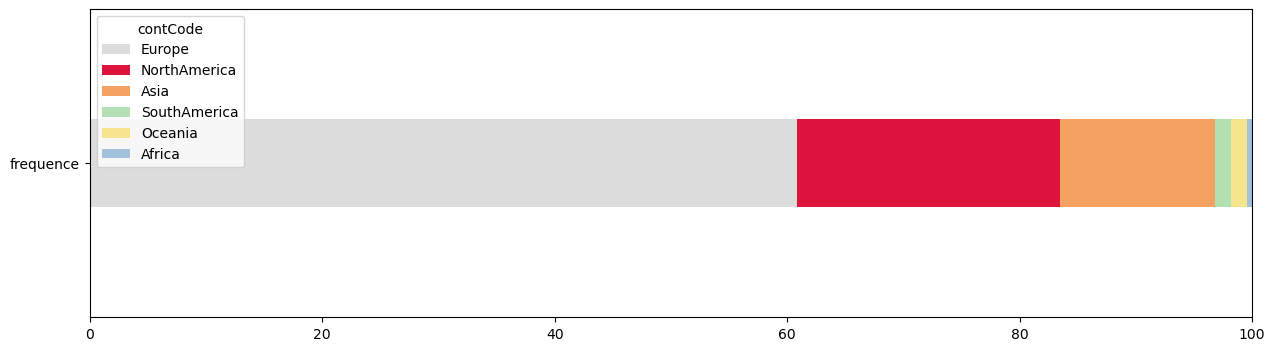

In [18]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,4), color=col_palette_1, width=0.2, xlim=[0,100])



### Codage par période de vingt-cinq ans

In [19]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 1975, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1851, 1876, 1901, 1926, 1951] 8


In [207]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [208]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,http://www.wikidata.org/entity/Q6581097,"Asia, Europe, Europe",Asia,1926-1950
1,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,http://www.wikidata.org/entity/Q6581097,Europe,Europe,1901-1925
2,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,http://www.wikidata.org/entity/Q6581097,"Asia, North America, North America",Asia,1901-1925


In [ ]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775     254
1776-1800     326
1801-1825     532
1826-1850     809
1851-1875    1312
1876-1900    1916
1901-1925    4210
1926-1950    8132
dtype: int64


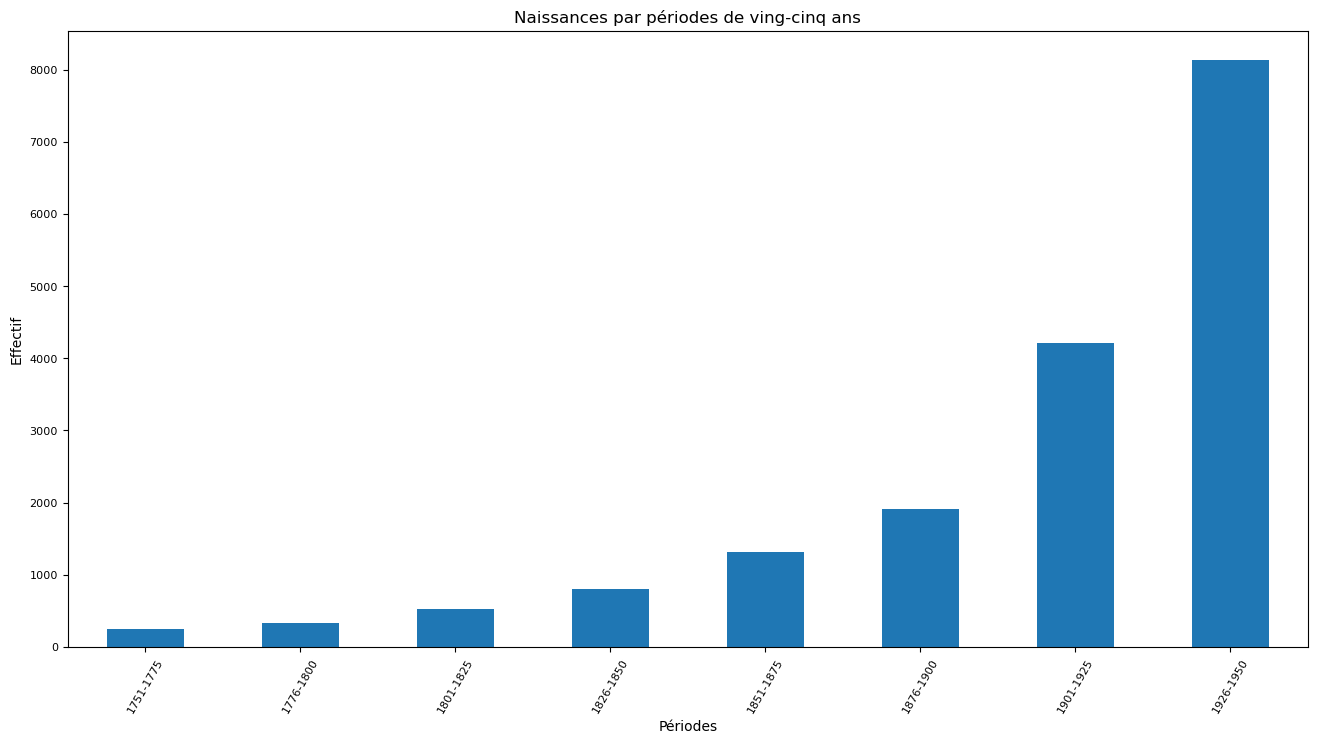

In [212]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des continents

In [214]:
lcont = list(sorted(set(df_p.contCode.to_list())))
lcont.remove('Europe')
print(lcont)

['Africa', 'Asia', 'NorthAmerica', 'Oceania', 'SouthAmerica']


In [215]:
### Regrouper et compter avec un fitre sur le continent 'Europe'
merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())
merged.columns = ['Europe']
merged.tail()



,Europe
per_25,
1826-1850,626
1851-1875,907
1876-1900,1257
1901-1925,2118
1926-1950,4790


In [216]:
### Ajouter les distributions des autres continents
for cont in lcont:
    new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
    new_df.columns = [cont]
    merged = pd.merge(merged, new_df, left_index=True, right_index=True)

merged    
    

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,226,0,8,19,0,1
1776-1800,278,1,3,41,2,1
1801-1825,442,2,8,75,2,3
1826-1850,626,2,7,160,8,6
1851-1875,907,5,42,319,26,13
1876-1900,1257,7,152,470,18,12
1901-1925,2118,18,702,1239,74,59
1926-1950,4790,41,1410,1628,108,155


In [217]:
### Transformer l'index en chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,226,0,8,19,0,1
1776-1800,278,1,3,41,2,1
1801-1825,442,2,8,75,2,3
1826-1850,626,2,7,160,8,6
1851-1875,907,5,42,319,26,13
1876-1900,1257,7,152,470,18,12
1901-1925,2118,18,702,1239,74,59
1926-1950,4790,41,1410,1628,108,155


In [ ]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette_2 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#A3C1DA",  # Light Blue : Africa    
    "#F4A261",  # Light Coral: Asia
    "#DC4B4B",   # indianred : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow :SouthAmerica
]


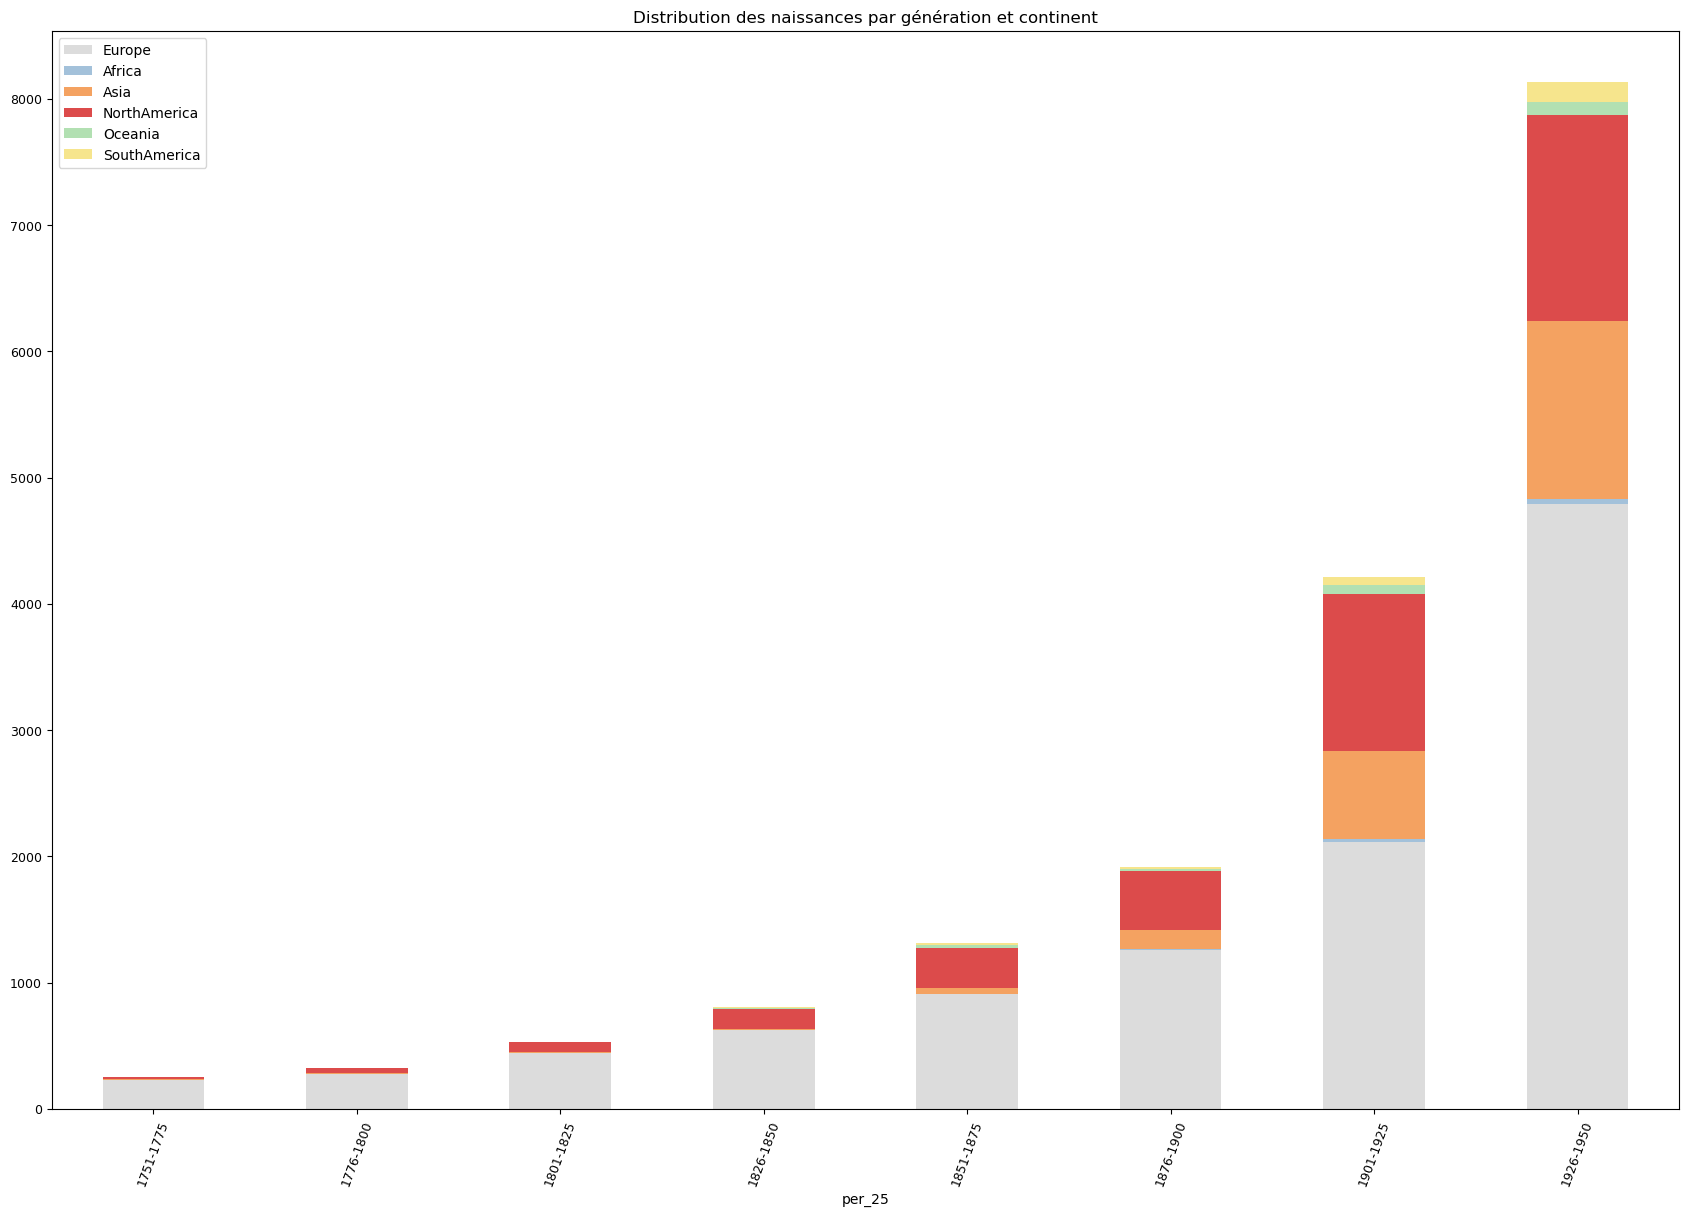

In [220]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(21,14), 
                     color=col_palette_2)
plt.title('Distribution des naissances par génération et continent')
plt.show()

## Représentation des mêmes informations avec une graphique décomposé




In [221]:
## L'information à représenter (la distribution des effectifs)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,226,0,8,19,0,1
1776-1800,278,1,3,41,2,1
1801-1825,442,2,8,75,2,3
1826-1850,626,2,7,160,8,6
1851-1875,907,5,42,319,26,13
1876-1900,1257,7,152,470,18,12
1901-1925,2118,18,702,1239,74,59
1926-1950,4790,41,1410,1628,108,155


In [222]:
### Fréquences par période
merged_prop = merged.apply(lambda x: (x / x.sum()) * 100, axis=1).round(1)
merged_prop

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,89.0,0.0,3.1,7.5,0.0,0.4
1776-1800,85.3,0.3,0.9,12.6,0.6,0.3
1801-1825,83.1,0.4,1.5,14.1,0.4,0.6
1826-1850,77.4,0.2,0.9,19.8,1.0,0.7
1851-1875,69.1,0.4,3.2,24.3,2.0,1.0
1876-1900,65.6,0.4,7.9,24.5,0.9,0.6
1901-1925,50.3,0.4,16.7,29.4,1.8,1.4
1926-1950,58.9,0.5,17.3,20.0,1.3,1.9


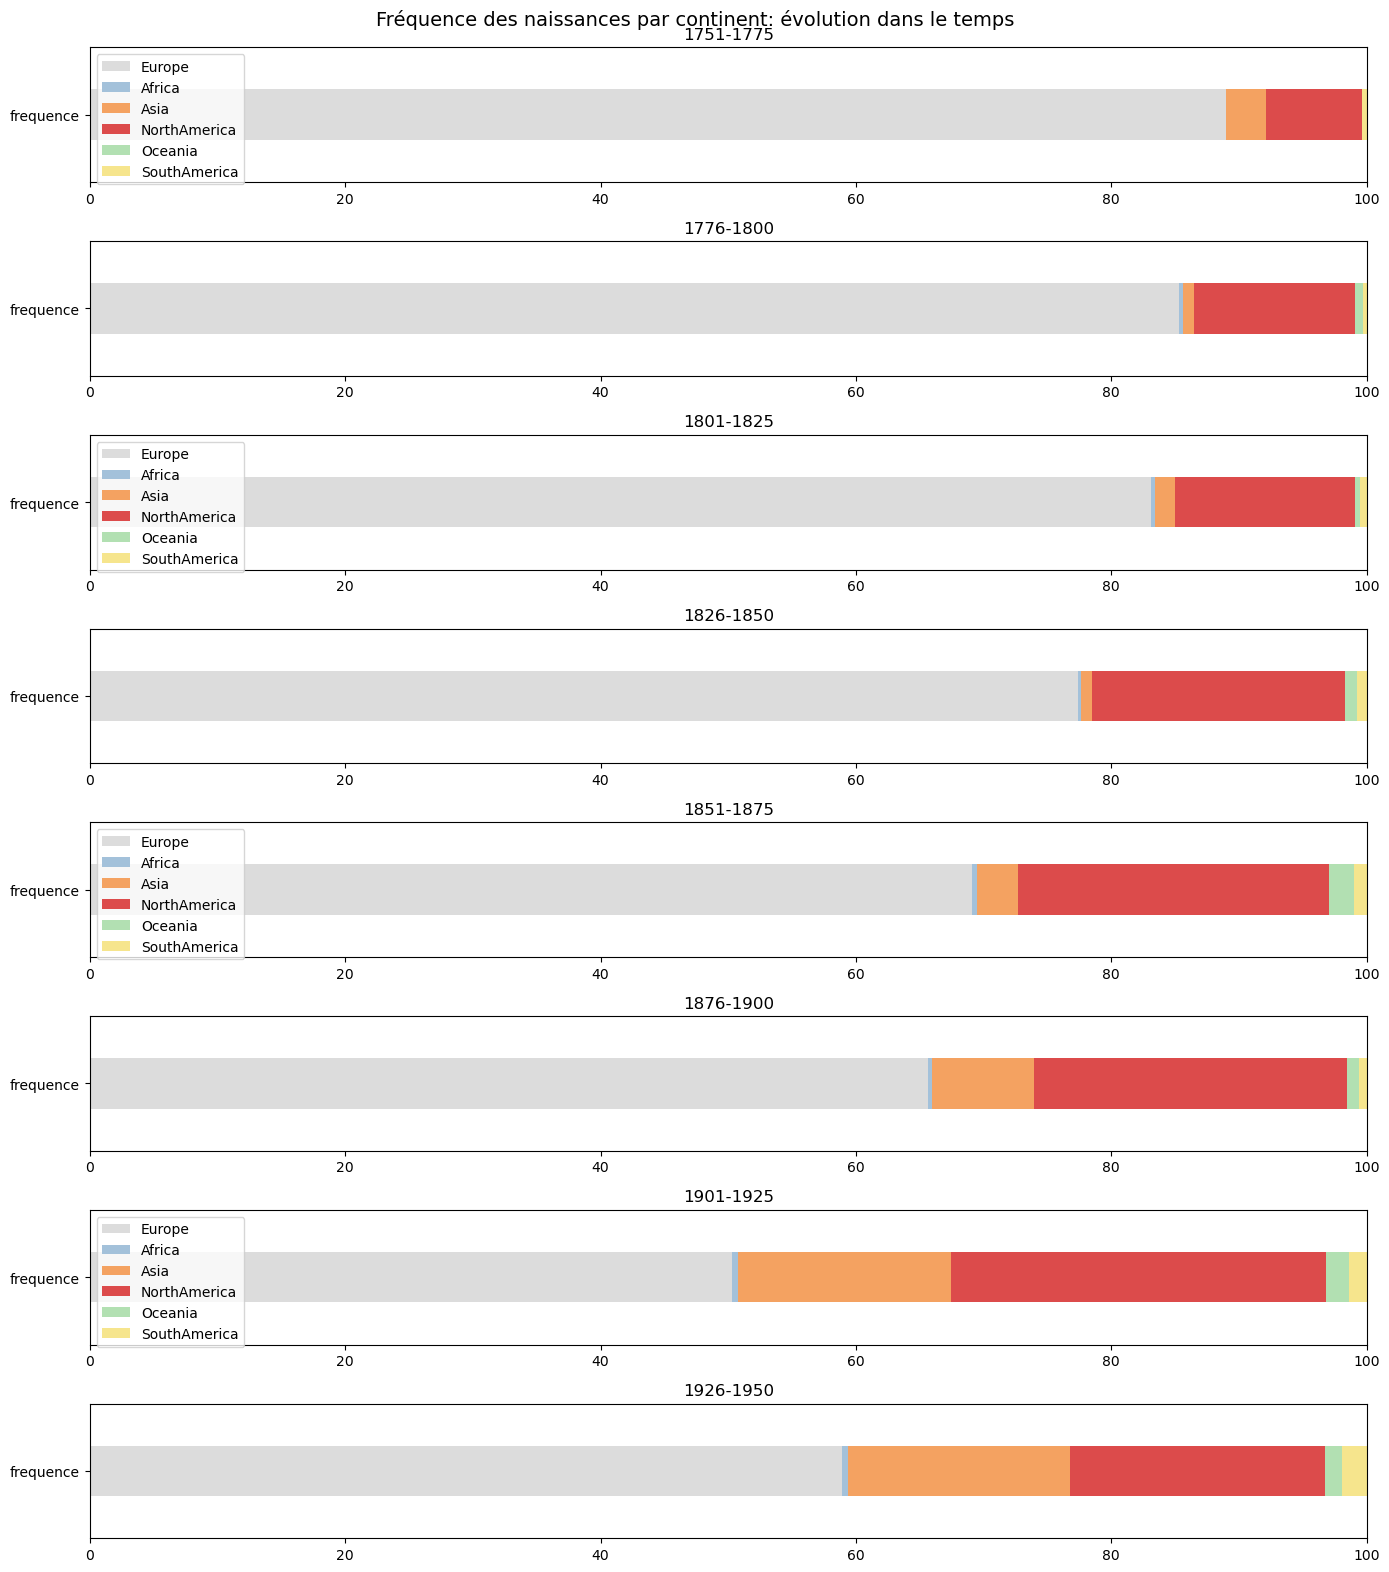

In [233]:
### Graphique multiple
#  Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/


lm = len(merged)

# Initialise the subplot function using number of rows and columns
#figure, axis = plt.subplots(lm, 1)

fig, axes = plt.subplots(lm, 1, figsize=(14,16))

i = 0

while i < lm:
    df = pd.DataFrame(merged.iloc[i , ])
    df['frequence'] = (100 * df / df.sum()).round(2)
    ljt = pd.DataFrame(df['frequence']).T
    # print(ljt)
    fig = ljt.plot(kind='barh', stacked=True, ax=axes[i], label=None, xlabel=None, 
                   fontsize=10, color=col_palette_2, width=0.3, xlim=[0,100])
    fig.set_title(df.columns[0])
    if (i+2)%2 != 0:
        fig.get_legend().remove()
    i += 1
    

plt.suptitle('Fréquence des naissances par continent: évolution dans le temps',  fontsize=14)
             
plt.tight_layout()  # rect=[0, 0.03, 1, 0.90]
plt.xlabel('')

   
plt.show()




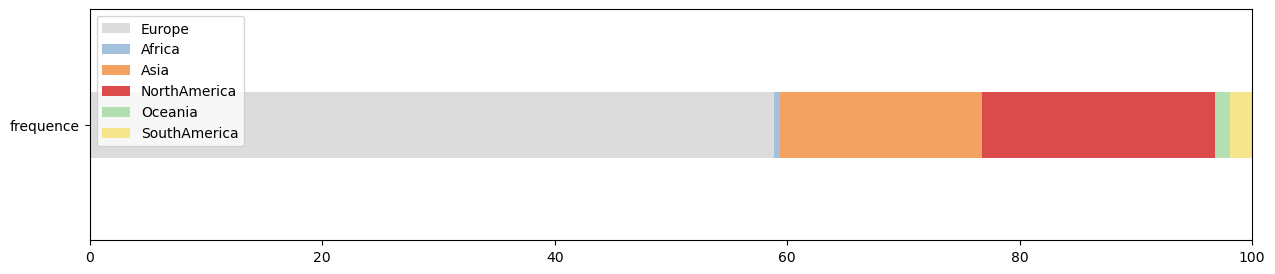

In [ ]:

### Comparer avec l'ensemble de la période !
# Noter que la distribution  de la dernière tranche temporelle est quasiment la même pour l'ensemble de la période 
# du fait des effectifs très importants du 20e siècle, qui définissent la tendance générale

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette_2, width=0.2, xlim=[0,100])

